This project will be exploring how to extract useful information from poorly extracted potentiometric titration data. The titration was done by adding a sample of standardized HCl solution (~0.102M) to a mixture of sodium bicarbonate $Na_{2}CO_{3}$, and sodium carbonate, $NaHCO_{3}$. Since $Na_{2}$ can be protonated twice using HCl, two infelction points are expected. 

The titration data used in this project was collected by using visual indicators, phenolphthalein and bromocresol green, however, error can arise when the infelction points determination relies solely on color interpretation, especially in some cases, the color change can be very subtle such as bromocresol green. Bromocresol green is blue when in a basic solution, and turns yellow in acidic, so the inflection point actually occurs when the solution turns green from blue. Such subtle change can be very difficult to interpret using the naked eyes, so more quantitative methods should be employed to determine the infelction points of the titration. 

The titration method used to collect the data was using a potentiometer to measure to pH. A potentiometer works by measuring the the potential of the analyte in equilibrium in the solution,$E_{cell}$, which is proportionally related to the cation activities $a_{X}$ with equilibrium constant K, by the Nernst equation:<br>
<center>$E_{cell}$ = K - $\frac{0.0592}n$log($\frac{1}{a_{X}}$)</center></h1><br>
Note that the equation assums standard temperature and pressure, and when $a_{X}$ is small, it can be approximated using the concentration of the analyte of interest. Since the pH meter measures pH, ${a_{X}}$ can be approximated using the concentration of [$H^{+}$]. After rearranging, the equation now becomes:<br>
<center>pH = -log$\frac{1}{a_{X}}$ = (K - $E_{cell}$)$\frac{0.0592}n$ </center></h1><br>

So in order to determine the inflection points quantitatively, the first or second derivitive method can be used. In a titration curve, the inflection point occurs when the pH changes the most rapidly since that is when the solution is not longer a buffer. So in terms of first derivative, that is when the rate of change at a local maxima. The inflection point can also be determined using the second derivative, which occurs when the value crosses the zero line, where the "zero-line test" would be required to determine the inflection point occurance. 

In [1]:
import pandas as pd
import scipy as sci
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# the first derivative was computed by calculating the change in pH per unit of change in volume added
# the second derivative was computed by the change of change in pH per squared unit of volume added

def derivatives (x,y):
    first_diff = np.abs(np.diff(y,1)/np.diff(x,1)).tolist()
    second_diff = (np.diff(y,2))/(np.diff(x[0:len(x)-1],1)**2).tolist()
    return first_diff, second_diff

In [3]:
# since the noise could not be smoothed using a curve, and we know there is only one true inflection point
# so the values with the largest difference the cross the horizontal axis would be the inflection point

# input takes the list contains the second derivative values
def inflection_2_2 (x,vol,ph):
    inflection_index = []
    differences = []

    for ii in range(1,len(x)):
        if x[ii]<0 and x[ii-1]>0:
            difference = x[ii] - x[ii-1]
            inflection_index.append([ii])
            differences.append([difference])
        elif x[ii]>0 and x[ii-1]<0:
            difference = x[ii] - x[ii-1]
            inflection_index.append([ii])
            differences.append([difference])
        elif x[ii] == 0:
            inflection_index.append([ii])

    # find the index with the largest differences
    # and locate the original value using the second derivative value
    # take the average value of the two that crossed the horizontal line

    val = inflection_index[differences.index(max(differences))]
    index = x.index(x[val[0]]) #index of the inflection point
    inflectin_vol_2 = (vol[index+1] + vol[index])/2
    ph_2_2 = (ph[index+1] + ph[index])/2
    
#returns the inflection point volume added and ph value using the 2nd derivative, 
    return(inflectin_vol_2,ph_2_2)

In [4]:
df = pd.read_csv('titration.csv')

In [5]:
vol_added = [0]

for ii in range(1,len(df)):
    vol = df['VolumeReading'].iloc[ii] - df['VolumeReading'].iloc[0]
    vol_added.append(vol)
ph = np.array(df['pH'])
df["vol_added"] = vol_added
total_vol = np.array(vol_added).reshape(1,-1)
total_ph = ph.reshape(1,-1)

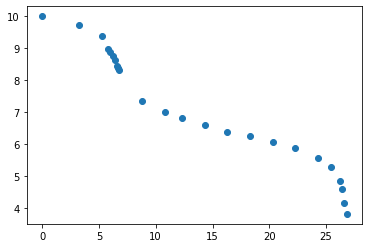

In [6]:
#check out how the data looks like

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(total_vol,total_ph)

From the plot above, the data was not smooth since they were taken by hand. It may also be not obvious that there were two inflection points, which was resulted from erroneous interpretation when using the visual indicators. 

Since there were two inflection points, the data was broekn down into two sets to analyze each inflection separately. 

In [7]:
#since there were two inflection points, so the data set was split into two to analyze each infelction point separately
#it looked like the value flattened out when the HCl was added mid-way, so the data would be split right in the middle

vol_added_1 = vol_added[:len(vol_added)//2]
ph_1 = ph[:len(vol_added)//2]

vol_added_2 = vol_added[len(vol_added)//2:-1]
ph_2 = ph[len(vol_added)//2:-1]

/Users/mirandalu/miniconda3/envs/che155/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


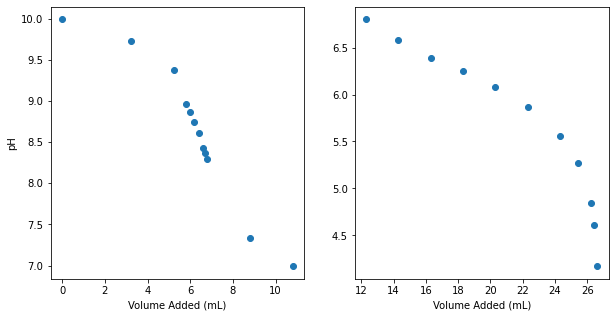

<Figure size 432x288 with 0 Axes>

In [8]:
# from the data, we can see that the second infleciton point should occur shortly after the last data point taken
# unfortunetely the experiment was cut off early, as the visual indicator had shown the titration was completed
# despite the fact that during the experiment, an additional 3 data points were taken to avoid the situation

fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(10,5))

fig = plt.figure()

ax1.scatter(vol_added_1,ph_1)
ax2.scatter(vol_added_2,ph_2)

ax1.set_ylabel("pH")
ax1.set_xlabel("Volume Added (mL)")
ax2.set_xlabel("Volume Added (mL)")


fig.show()

For the first inflection point data, a sigmoid curve can be used. A sigmoid curve takes in the form of: <br>
<center> S(x) = $\frac{1}{1+e^{-x}}$ <center>
And the parameters used to optimized the functions are: A:lower asymptote,  B:upper asymptote, C:inflection point, D: slope of the curve. With the parameters, the equaion now looks like:
<center>S(x) = $\frac{A-D}{1+({\frac{x}C)^B}}$ <center>
Since the logistics function is fitted using 4 parameters, it's also known as the "4-parameter logistics" function, or "4PL". 

In [9]:
import scipy.optimize as opt
from scipy.optimize import curve_fit

def sigmoid(x, A, B, C, D):
    return ((A-D)/(1.0+((x/C)**B))) + D

/Users/mirandalu/miniconda3/envs/che155/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in power
  """


[ 6.81930776 -6.0147057   6.72985084  9.89041547]


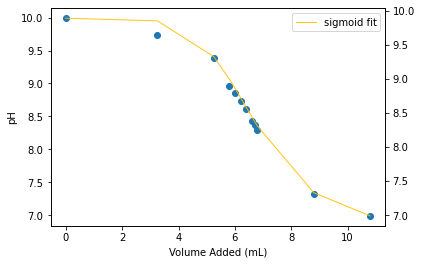

In [10]:
#parameters, covariances = curve_fit(gauss, freq, amp, p0=[noise_level,amplitude,center_freq, 0.13])
#the initial guess were done by eyeballing, which wasn't difficult since there wasn't much data to work wtith

guess = [7, -0.7, 7, 10]

params, params_covariance = curve_fit(sigmoid, vol_added_1, ph_1, guess)

fig = plt.figure()
ax1 = fig.add_subplot()
ax1.scatter(vol_added_1,ph_1)

ax2 = ax1.twinx()
ax2.plot(vol_added_1, sigmoid(vol_added_1, *params),label = "sigmoid fit", color='#FFBF00', linewidth=1., alpha=0.9)

ax1.set_ylabel("pH")
ax1.set_xlabel("Volume Added (mL)")
ax2.legend()

print(params)

the average residuals after curve fitting is 2.3709848899026536e-10


/Users/mirandalu/miniconda3/envs/che155/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in power
  """


Text(0.5, 0, 'volume_added (mL)')

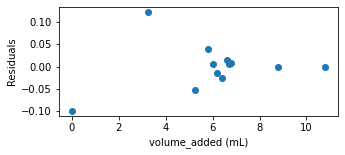

In [11]:
# calculate residuals
# the residuals is in the magnitude of E-10, the fit was good!

residuals = sigmoid(vol_added_1, *params) - ph_1
print(f'the average residuals after curve fitting is {np.average(residuals)}')

plt.figure(figsize=(5,2))
fig = plt.scatter(vol_added_1,residuals)
plt.ylabel("Residuals")
plt.xlabel("volume_added (mL)")

In [12]:
opt_sigmoid = sigmoid(vol_added_1, params[0], params[1],params[2],params[3])

first_diff, second_diff = derivatives(vol_added_1,opt_sigmoid)
inflection_1 = first_diff.index(max(first_diff))

/Users/mirandalu/miniconda3/envs/che155/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in power
  """


/Users/mirandalu/miniconda3/envs/che155/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in power
  """
/Users/mirandalu/miniconda3/envs/che155/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in power
  """


Text(0, 0.5, '2nd derivative')

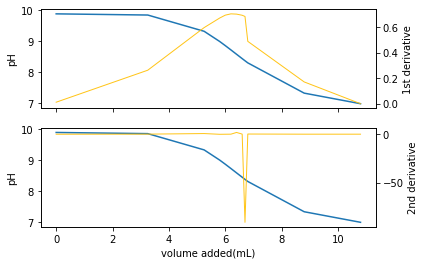

<Figure size 432x288 with 0 Axes>

In [13]:
fig, (ax1, ax3) = plt.subplots(2, 1, sharex=True)
fig = plt.figure()

ax1.plot(vol_added_1, sigmoid(vol_added_1, *params))
ax1.set_ylabel("pH")

ax2 = ax1.twinx()
ax2.plot(vol_added_1, first_diff + [0], color='#FFBF00', linewidth=1., alpha=0.9)
ax2.set_ylabel("1st derivative")

ax3.plot(vol_added_1, sigmoid(vol_added_1, *params))
ax3.set_ylabel("pH")
ax3.set_xlabel("volume added(mL)")

ax4 = ax3.twinx()
ax4.plot(vol_added_1, second_diff.tolist()+[0]*(len(vol_added_1)-len(second_diff)), color = '#FFBF00', linewidth=1., alpha=0.9)
ax4.set_ylabel("2nd derivative")

In [14]:
# computing the inflection point using the second derivative
opt_sigmoid = opt_sigmoid.tolist()
second_diff = second_diff.tolist()
inflection_vol_2,inflection_ph_2 = inflection_2_2(second_diff,vol_added_1,opt_sigmoid)

In [15]:
print(f'The first derivative showed the first inflection point has a pH value of {ph_1[inflection_1]} with {vol_added_1[int(inflection_1)]:.1f} mL HCl added')
print(f'The second derivative showed the first inflection point has a pH value of {inflection_ph_2:.2f} with {inflection_vol_2:.1f} mL HCl added')

The first derivative showed the first inflection point has a pH value of 8.74 with 6.2 mL HCl added
The second derivative showed the first inflection point has a pH value of 7.82 with 7.8 mL HCl added


Since technically the second inflection point titration was barely completed, a sigmoid function would not work, an alternative had to be used to smooth the noise and to derive the derivitavies. A safe bet with the curve seemed to be a polynomial, so a 4th degree polynomial was used as a best fit. <br>

In [16]:
# the curve for the second inflection point may be fitted with a polynomial, so a 4th-degree polynomial was fitted and plotted here

def polynomials(x,F, E, D, C, B, A):
    return F*x**5+E*x**4+D*x**3+C*x**2+B*x+A

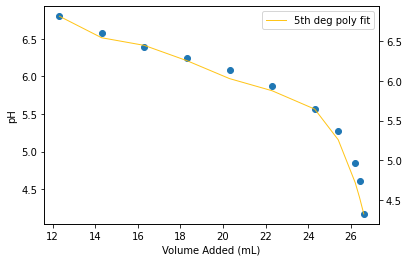

In [17]:
#the curve seem to be a pretty good fit!

coeff= np.polyfit(vol_added_2,ph_2,5).tolist()

fitted_ph_2 = []
for ii in range(len(vol_added_2)):
    poly_fit = polynomials(vol_added_2[ii], 
                           float(coeff[0]),float(coeff[1]),float(coeff[2]),float(coeff[3]),float(coeff[4]),float(coeff[5]))
    fitted_ph_2.append(poly_fit)

fig = plt.figure()
ax1 = fig.add_subplot()
ax1.scatter(vol_added_2,ph_2)

ax2 = ax1.twinx()
ax2.plot(vol_added_2, fitted_ph_2, label = "5th deg poly fit", color='#FFBF00', linewidth=1., alpha=0.9)

ax1.set_ylabel("pH")
ax1.set_xlabel("Volume Added (mL)")
ax2.legend()

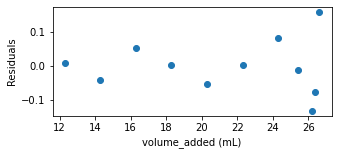

The average residuals after curve fitting is -6.710591678297946e-13


In [18]:
# calculate the residuals, the residuals are in the order of magnitude of 10^-3 which is within tolerance

residuals_2 = fitted_ph_2 - ph_2

plt.figure(figsize=(5,2))
fig = plt.scatter(vol_added_2,residuals_2)
plt.ylabel("Residuals")
plt.xlabel("volume_added (mL)")
plt.show()

print(f'The average residuals after curve fitting is {np.average(residuals_2)}')

In [19]:
#calculate the derivatives

first_diff_2, second_diff_2 = derivatives(vol_added_2,fitted_ph_2)
inflection_2 = first_diff_2.index(max(first_diff_2))

Text(0.5, 0, 'volume added(mL)')

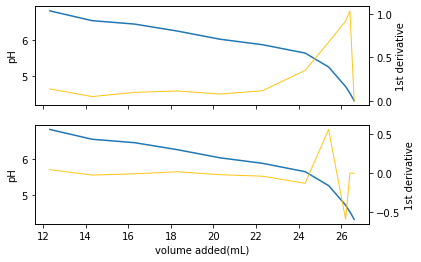

<Figure size 432x288 with 0 Axes>

In [20]:
fig, (ax1, ax3) = plt.subplots(2, 1, sharex=True)
fig = plt.figure()

ax1.plot(vol_added_2, fitted_ph_2)
ax1.set_ylabel("pH")

ax2 = ax1.twinx()
ax2.plot(vol_added_2, first_diff_2 + [0], color='#FFBF00', linewidth=1., alpha=0.9)
ax2.set_ylabel("1st derivative")


ax3.plot(vol_added_2, fitted_ph_2)
ax3.set_ylabel("pH")
ax4 = ax3.twinx()
ax4.plot(vol_added_2, second_diff_2.tolist()+[0]*(len(vol_added_1)-len(second_diff)), color='#FFBF00', linewidth=1., alpha=0.9)
ax4.set_ylabel("1st derivative")

ax3.set_xlabel("volume added(mL)")

In [21]:
# from the plot, the second derivative seems to be significantly off from where the inflection point is by eyeballing
second_diff_2 = second_diff_2.tolist()
inflection_vol_2,inflection_ph_2 = inflection_2_2(second_diff_2,vol_added_2,fitted_ph_2)

print(f'The first derivative showed the second inflection point has a pH value of {ph_2[inflection_2]} with {vol_added_2[int(inflection_2)]:.1f} mL HCl added')
print(f'The second derivative showed the second inflection point has a pH value of {inflection_ph_2:.2f} with {inflection_vol_2:.1f} mL HCl added')

The first derivative showed the second inflection point has a pH value of 4.61 with 26.4 mL HCl added
The second derivative showed the second inflection point has a pH value of 4.99 with 25.8 mL HCl added


In [22]:
# calculate the relative concentration of sodium carbonate and sodium bicarbonate in the sample
# there was too much uncertainties when second derivative was used, so first derivative was used to compute the final results
# HCl standardized concentration was in M, the molar mass of Na2CO3 was 105.00g/mol and NaHCO3 was 84.007g/mol

hcl_standard = 0.1028 
Na2CO3 = vol_added_1[int(inflection_1)] * hcl_standard *10**(-3) * 105.99
NaHCO3 = vol_added_2[int(inflection_2)] * hcl_standard *10**(-3) * 84.007

print(f'Thre was {Na2CO3:0.5f}g of sodium carbonate and {NaHCO3:0.5f}g of sodumn bicarbonate in the sample')
print(f'The relative composition was {(Na2CO3/(Na2CO3+NaHCO3)*100):0.2f}% of sodium carbonate and {(NaHCO3/(Na2CO3+NaHCO3)*100):0.2f}% of sodium bicarbonate')

Thre was 0.06755g of sodium carbonate and 0.22799g of sodumn bicarbonate in the sample
The relative composition was 22.86% of sodium carbonate and 77.14% of sodium bicarbonate
